In [ ]:
#import data by kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
#dataset API
!kaggle datasets download -d harisalikhan/dog-breeds

100% 1.05G/1.05G [00:53<00:00, 22.2MB/s]
100% 1.05G/1.05G [00:53<00:00, 21.2MB/s]


In [ ]:
#file unzip
import zipfile
zip_ref = zipfile.ZipFile('/content/dog-breeds.zip') 
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from  keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,MaxPool2D,Dropout,Dense,Flatten,MaxPooling2D
from keras.callbacks import EarlyStopping

In [ ]:
train_data = "/content/dogImages/train"
test_data = "/content/dogImages/test"
val_data = "/content/dogImages/valid"

In [12]:
tf.keras.preprocessing.image_dataset_from_directory(
    train_data,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
    )

Found 6680 files belonging to 133 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
train_data=tf.keras.preprocessing.image_dataset_from_directory(train_data,validation_split=0.2,
                                                               image_size=(224,224),
                                                               batch_size=32,
                                                               subset="training",
                                                               seed=123)

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_data,validation_split=0.2,
                                                               image_size=(224,224),
                                                               batch_size=32,
                                                               subset="validation",
                                                               seed=123)

val_data=tf.keras.preprocessing.image_dataset_from_directory(val_data,validation_split=0.2,
                                                               image_size=(224,224),
                                                               batch_size=32,
                                                               subset="validation",
                                                               seed=123)

Found 6680 files belonging to 133 classes.
Using 5344 files for training.
Found 836 files belonging to 133 classes.
Using 167 files for validation.
Found 835 files belonging to 133 classes.
Using 167 files for validation.


In [14]:
class_names = train_data.class_names
class_names

['001.Affenpinscher',
 '002.Afghan_hound',
 '003.Airedale_terrier',
 '004.Akita',
 '005.Alaskan_malamute',
 '006.American_eskimo_dog',
 '007.American_foxhound',
 '008.American_staffordshire_terrier',
 '009.American_water_spaniel',
 '010.Anatolian_shepherd_dog',
 '011.Australian_cattle_dog',
 '012.Australian_shepherd',
 '013.Australian_terrier',
 '014.Basenji',
 '015.Basset_hound',
 '016.Beagle',
 '017.Bearded_collie',
 '018.Beauceron',
 '019.Bedlington_terrier',
 '020.Belgian_malinois',
 '021.Belgian_sheepdog',
 '022.Belgian_tervuren',
 '023.Bernese_mountain_dog',
 '024.Bichon_frise',
 '025.Black_and_tan_coonhound',
 '026.Black_russian_terrier',
 '027.Bloodhound',
 '028.Bluetick_coonhound',
 '029.Border_collie',
 '030.Border_terrier',
 '031.Borzoi',
 '032.Boston_terrier',
 '033.Bouvier_des_flandres',
 '034.Boxer',
 '035.Boykin_spaniel',
 '036.Briard',
 '037.Brittany',
 '038.Brussels_griffon',
 '039.Bull_terrier',
 '040.Bulldog',
 '041.Bullmastiff',
 '042.Cairn_terrier',
 '043.Canaan_do

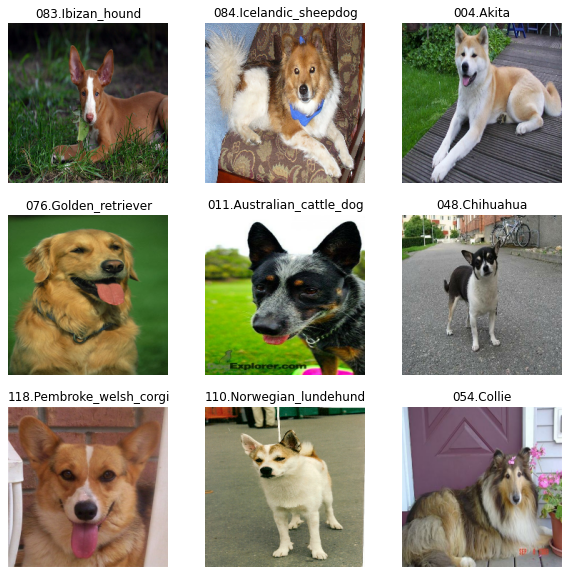

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [16]:
# Criando o modelo base em cima do modelo MobileNetV3
base_model = keras.applications.MobileNetV3Small(input_shape=(224, 224, 3),
                                            classes=400,
                                            include_top=False,
                                            weights='imagenet')

4334752/4334752 [==============================] - 0s 0us/step


In [17]:
# Freeze convolutional base
base_model.trainable = False
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [18]:
data_augmentation = keras.models.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.2)
])

In [19]:
num_classes = len(class_names)

inputs = keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = keras.applications.mobilenet_v3.preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)


outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [20]:
#compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 133)               76741     
                                                                 
Total params: 1,015,861
Trainable params: 76,741
Non-trainabl

In [21]:
#fitting model
initial_epochs = 10

early_stop = keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)

history = model.fit(train_data, 
          validation_data=test_data,
          epochs=initial_epochs,
          callbacks=[early_stop])

Epoch 1/10
167/167 [==============================] - 30s 119ms/step - loss: 3.4020 - accuracy: 0.2620 - val_loss: 2.0066 - val_accuracy: 0.5509
Epoch 2/10
167/167 [==============================] - 19s 110ms/step - loss: 1.6199 - accuracy: 0.6037 - val_loss: 1.3395 - val_accuracy: 0.6707
Epoch 3/10
167/167 [==============================] - 20s 113ms/step - loss: 1.1104 - accuracy: 0.7376 - val_loss: 1.1264 - val_accuracy: 0.7186
Epoch 4/10
167/167 [==============================] - 20s 113ms/step - loss: 0.8665 - accuracy: 0.7831 - val_loss: 0.9718 - val_accuracy: 0.7545
Epoch 5/10
167/167 [==============================] - 20s 112ms/step - loss: 0.7273 - accuracy: 0.8249 - val_loss: 0.9284 - val_accuracy: 0.7545
Epoch 6/10
167/167 [==============================] - 19s 112ms/step - loss: 0.6083 - accuracy: 0.8524 - val_loss: 0.9079 - val_accuracy: 0.7305
Epoch 7/10
167/167 [==============================] - 19s 112ms/step - loss: 0.5269 - accuracy: 0.8739 - val_loss: 0.8701 - val_ac

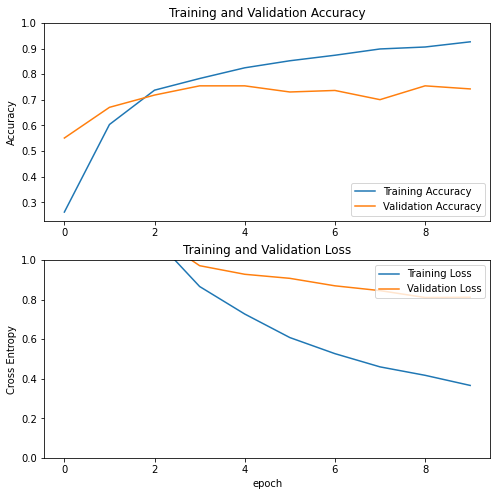

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
#Visualize the result
results = model.evaluate(test_data, verbose=0)

In [24]:
print("Test Loss: {:.5f}".format(results[0]))
print("Accuracy on the test set: {:.2f}%".format(results[1] * 100))

Test Loss: 0.81075
Accuracy on the test set: 75.45%


1/1 [==============================] - 1s 732ms/step


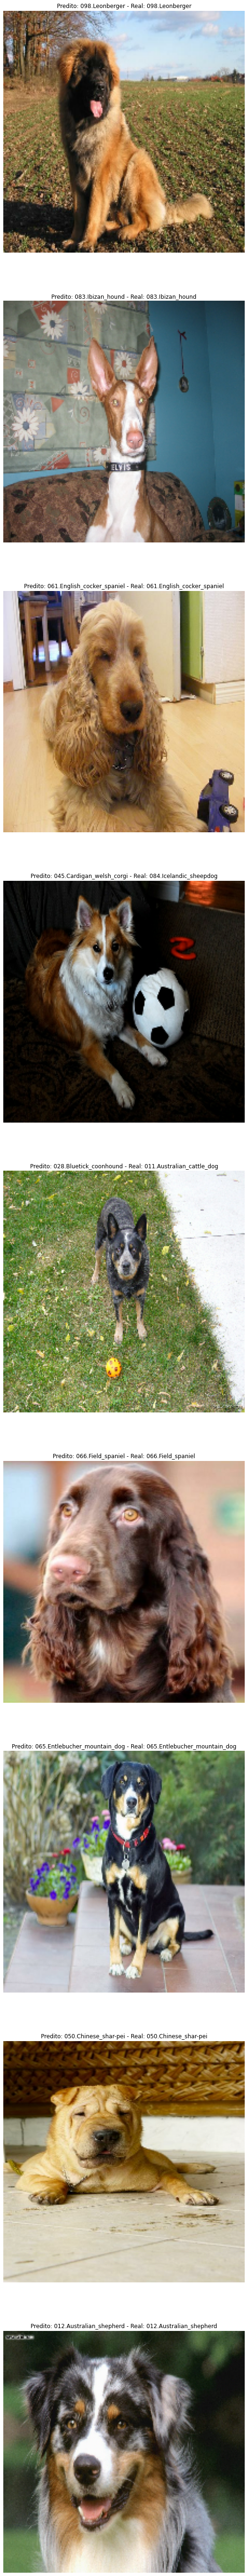

In [25]:
#model testing
plt.figure(figsize=(10, 100))
for images, labels in test_data.take(1):
    prediction = model.predict(images,batch_size=32)
    for i in range(9):
        ax = plt.subplot(9, 1, i+1)
        pred = np.argmax(prediction[i])
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'Predito: {class_names[pred]} - Real: {class_names[labels[i]]}')
        plt.axis('off')